In [ ]:
import scanpy as sc
import pycisTopic
from pycisTopic.cistopic_class import *
import pickle
import os
import anndata
import mudata
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from pyvis.network import Network
from scipy.stats import fisher_exact



/home/junyichen/anaconda3/envs/scenicplus/lib/python3.11/site-packages/pycisTopic/__init__.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


In [288]:
def visualize_regulatory_network(metadata_df, importance_col='importance', weight_col='importance_TF2G',figure_size=(8, 7),
                               top_n=100, output_html='figures/network.html',title='SCENIC+ Regulatory Network',df_deg=None):
    """
    Visualize SCENIC+ regulatory network with TF-gene relationships
    
    Parameters:
        metadata_df: DataFrame with columns ['TF', 'gene', importance_col, 'region']
        importance_col: Column name for TF-gene importance scores
        top_n: Number of top interactions to visualize
        output_html: Output file name for interactive visualization
    """
    # Prepare data
    # Sort by the absolute importance and select top_n interactions

    df = metadata_df.sort_values(importance_col, ascending=False).head(top_n)
    #df = metadata_df.sort_values(importance_col, ascending=False)
    
    # Create network graph
    G = nx.DiGraph()
    
    # Add nodes and edges with importance as weight
    for _, row in df.iterrows():
        G.add_edge(row['TF'], row['Gene'], 
                  weight=row[weight_col],
                  title=f"Importance: {row[weight_col]:.2f}")
        
    degrees = dict(G.degree())
    max_degree = max(degrees.values()) if degrees else 1

    
    # Node colors (TFs in red, genes in blue)
    # Node colores, where TFs are orange and genes are magenta, not in df_deg are gray

    node_colors = {}
    node_edge_colors = {}
    node_edge_widths = {}

    for node in G.nodes():
        if node in df['TF'].unique() and node in df_deg['gene'].unique():
            if df_deg[df_deg['gene'] == node]['condition'].values[0] == 'UP':
                node_colors[node] = '#F6607C'
                node_edge_colors[node] = '#F6607C'  # Light red outline
                node_edge_widths[node] = 3
            else:
                node_colors[node] = '#63ADF2'
                node_edge_colors[node] = '#63ADF2'  # Light green outline
                node_edge_widths[node] = 3

        elif node in df['Gene'].unique() and node in df_deg['gene'].unique():
            if df_deg[df_deg['gene'] == node]['condition'].values[0] == 'UP':
                node_colors[node] = 'lightcoral'
                node_edge_colors[node] = 'lightcoral'
                node_edge_widths[node] = 3

            else:
                node_colors[node] = '#ADD8E6'
                node_edge_colors[node] = '#ADD8E6'
                node_edge_widths[node] = 3

        else:
            node_colors[node] = 'lightgray'  # For nodes not in df_deg
            node_edge_colors[node] = 'lightgray'
            node_edge_widths[node] = 0


    # node_colors = {
    #     node: 'orange' if node in df['TF'].unique() else 'magenta'
    #     for node in G.nodes()
    # }
    
    # Static visualization
    plt.figure(figsize=figure_size)
    pos = nx.spring_layout(G, k=0.1, iterations=50,scale=0.5)
    #pos = nx.kamada_kawai_layout(G, scale=0.8)
    
    # Draw nodes


    #node_sizes_d = [degrees[n] * 800 / max_degree for n in G.nodes()]
    #node size = abs log2 fold change in df_deg
    node_sizes = []
    for n in G.nodes():
        if n in df_deg['gene'].unique():
            fold_change = df_deg[df_deg['gene'] == n]['de_coef'].values[0]
            node_sizes.append(abs(fold_change) * 400 + degrees[n]*400 / max_degree)
        else:
            node_sizes.append(100)

    # node_sizes = [degrees[n] * 800 / max_degree for n in G.nodes()]
    # nx.draw_networkx_nodes(G, pos, node_color=[node_colors[n] for n in G.nodes()],
    #                                edgecolors=[node_edge_colors[n] for n in G.nodes()],
    #                 linewidths=[node_edge_widths[n] for n in G.nodes()],
    #                       node_size=node_sizes, alpha=0.8)


    node_shapes = {n: 'h' if n in df['TF'].unique() else 'o' for n in G.nodes()}

# 分批次绘制不同形状的节点
    for shape in set(node_shapes.values()):
        nx.draw_networkx_nodes(
            G, pos,
            nodelist=[n for n in G.nodes() if node_shapes[n] == shape],
            node_shape=shape,
            node_color=[node_colors[n] for n in G.nodes() if node_shapes[n] == shape],
            edgecolors=[node_edge_colors[n] for n in G.nodes() if node_shapes[n] == shape],
            linewidths=[node_edge_widths[n] for n in G.nodes() if node_shapes[n] == shape],
            node_size=[node_sizes[i] for i, n in enumerate(G.nodes()) if node_shapes[n] == shape],
            alpha=0.8
        )


    # Draw edges with width proportional to importance
    edge_widths = [d['weight']*2 for u, v, d in G.edges(data=True)]
    # nx.draw_networkx_edges(G, pos, width=edge_widths, 
    #                       edge_color='gray', alpha=0.6, 
    #                       arrowstyle='-|>', arrowsize=15)
    for u, v, d in G.edges(data=True):
        arrowstyle = '-|>' if d['weight'] >= 0 else '-['
        color = 'lightgray' if d['weight'] >= 0 else 'pink'
        nx.draw_networkx_edges(
            G, pos, edgelist=[(u, v)],
            width=abs(d['weight'])*2,
            edge_color=color,
            alpha=0.6,
            arrowstyle=arrowstyle,
            arrowsize=15
        )
    import matplotlib.patheffects as path_effects

    # Draw labels
    text_labels = nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif',bbox=dict(facecolor='none',  pad=0.1, edgecolor='none'))
    for _, label in text_labels.items():
        label.set_path_effects([
            path_effects.Stroke(linewidth=2, foreground='white'),
            path_effects.Normal()
        ])

    plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(output_html+".png", dpi=300)
    plt.show()
    
    # Interactive visualization
    net = Network(height='800px', width='100%', directed=True)
    net.from_nx(G)


    for node in net.nodes:
        if node['id'] in df['TF'].unique():
            node['shape'] = 'triangle'

    # Save interactive version
    net.show_buttons(filter_=['physics'])
    net.save_graph(output_html)
    print(f"Interactive visualization saved to {output_html}")

In [277]:
cac_gene_dict = {'α1 subunit': ['Cacna1a',
  'Cacna1b',
  'Cacna1c',
  'Cacna1d',
  'Cacna1e',
  'Cacna1g',
  'Cacna1h',
  'Cacna1i'],
 'α2δ subunit': ['Cacna2d1', 'Cacna2d2', 'Cacna2d3', 'Cacna2d4'],
 'β subunit': ['Cacnb1', 'Cacnb2', 'Cacnb3', 'Cacnb4'],
 'γ subunit': ['Cacng2', 'Cacng3', 'Cacng4', 'Cacng5', 'Cacng7', 'Cacng8'],
 'None': ['Cacfd1', 'Cachd1']}

ca_genes = ['Cacna1a', 'Cacna1b', 'Cacna1c', 'Cacna1d', 'Cacna1e', 'Cacna1g', 
            'Cacna1h', 'Cacna1i', 'Cacna2d1', 'Cacna2d2', 'Cacna2d3', 'Cacna2d4', 
            'Cacnb1', 'Cacnb2', 'Cacnb3', 'Cacnb4', 'Cacng2', 'Cacng3', 'Cacng4', 
            'Cacng5', 'Cacng7', 'Cacng8', 'Cacfd1', 'Cachd1']


ligand = ['Slc18a2', 'Slc18a1', 'Ddc', 'Th', 'Slc17a7', 'Slc17a8', 'Gls',
       'Slc17a6', 'Slc18a3', 'Chat', 'Slc32a1', 'Dbh', 'Tph2', 'Tph1', 'Gad2',
       'Gad1', 'Pnmt', 'Shmt2', 'Shmt1', 'Hmox2', 'Nos3', 'Hmox1', 'Cort',
       'Nos2', 'Nos1', 'Sst', 'Adcyap1', 'Rln1', 'Nrxn3', 'Npy', 'Nrxn2',
       'Nrxn1', 'Pdyn', 'Vip', 'Trh', 'Crh', 'Nts', 'Penk', 'Tac1', 'Pthlh',
       'Pnoc', 'Tac2', 'Gjc1', 'Gjc2', 'Gjc3', 'Gjd2', 'Gjd3', 'Gjd4', 'Gje1',
       'Gjb6', 'Gjb5', 'Gjb4', 'Gjb3', 'Gjb2', 'Gjb1', 'Gja8', 'Gja6', 'Cck',
       'Grp', 'Gja5', 'Gja4', 'Gja1', 'Gja3', 'Gja10', 'Nmb']

receptor = ['Oprl1', 'Gabra6', 'Grik3', 'Gabrb3', 'Grik5', 'Adrb1', 'Oprd1', 'Gabra4', 
            'Grm5', 'Drd4', 'Npy1r', 'Grin2c', 'Slc6a4', 'Gjc3', 'Chrna7', 'Rxfp1', 'Adra1b', 
            'Gjb1', 'Oprm1', 'Nlgn2', 'Drd5', 'Chrm5', 'Gabra1', 'Htr5a', 'Pth1r', 'Oprk1', 'Tacr3', 
            'Chrna1', 'Grm7', 'Grik2', 'Chrna6', 'Adra1a', 'Gucy1b2', 'Slc6a3', 'Adra2b', 'Gabbr1', 'Chrna4', 
            'Gjb4', 'Htr1b', 'Gja1', 'Npy2r', 'Gucy1a1', 'Gabrb1', 'Grin1', 'Adra2a', 'Tacr1', 'Adrb2', 'Sstr2', 
            'Grin3a', 'Glra2', 'Slc6a2', 'Drd3', 'Htr1d', 'Adra2c', 'Htr2c', 'Grin2d', 'Chrnb1', 'Chrnb2', 'Gja4', 'Htr7', 
            'Htr2b', 'Gabra3', 'Ache', 'Grik4', 'Htr6', 'Grm1', 'Sstr4', 'Gjb2', 'Grm6', 'Adcyap1r1', 'Adra1d', 'Gria2', 
            'Chrna2', 'Grm3', 'Grik1', 'Chrm3', 'Rxfp3', 'Chrna10', 'Chrng', 'Gjb3', 'Crhr2', 'Grin3b', 'Gria3', 'Vipr1', 'Gria1', 
            'Grin2b', 'Htr4', 'Slc6a9', 'Npy5r', 'Gja3', 'Htr1f', 'Chrnb3', 'Gjd4', 'Nlgn3', 'Gjd2', 'Grm4', 'Sstr1', 'Grin2a', 'Gabrg2', 
            'Adrb3', 'Grm2', 'Gja8', 'Glra3', 'Gje1', 'Comt', 'Sstr3', 'Gjb5', 'Gabra2', 'Rxfp2', 'Chrne', 'Gabrg3', 'Vipr2', 'Cckbr', 'Htr1a', 
            'Chrm2', 'Gucy1a2', 'Htr2a', 'Ntsr2', 'Ntsr1', 'Htr3b', 'Gabrb2', 'Gja6', 'Drd2', 'Glra1', 'Grm8', 'Chrnd', 'Nmbr', 'Glrb', 'Trhr', 
            'Gria4', 'Gja5', 'Chrna9', 'Gucy1b1', 'Nlgn1', 'Drd1', 'Gjc1', 'Glra4', 'Crhr1', 'Chrna5', 'Gjc2', 'Gjd3', 'Trhr2', 'Gabra5', 'Htr1e', 
            'Htr3a', 'Slc6a5', 'Gja10', 'Chrna3', 'Chrm4', 'Gjb6', 'Chrnb4', 'Chrm1', 'Gabrg1', 'Gabbr2', 'Grpr']


respriotory = ['mt-Co1', 'mt-Co2', 'mt-Co3', 'mt-Atp6', 'mt-Nd4', 'mt-Nd1', 'Cox6c',
       'Cox8a', 'Cox4i1', 'Sdha', 'Ndufa4', 'Ndufs4', 'Cox7c', 'Ndufc2',
       'Ndufaf7', 'Ndufa13', 'Atp5f1', 'Ndufaf4', 'Cox7a2', 'Cox7b', 'Cox6a1',
       'Ndufs1', 'Ndufv2', 'Ndufb5', 'Uqcrh', 'Uqcrc2', 'Ndufaf2', 'Ndufb9',
       'Cox5a', 'Ndufa10', 'Ndufb1-ps', 'mt-Nd2', 'Ndufa6', 'Cox5b', 'Ndufb11',
       'Ndufb3', 'Cox6b1', 'Ndufs3', 'Uqcrq', 'Cyc1', 'Ndufb4', 'Coq2', 'Sdhb',
       'Ndufa7', 'Ndufs7', 'Ndufa12', 'Ndufb8', 'Ndufa11', 'Ndufb10', 'Ndufa3',
       'Coa3', 'Uqcrb', 'Ndufab1', 'Ndufa5', 'Uqcrc1', 'Sod2', 'Uqcr11',
       'Uqcr10', 'Sdhc', 'Ndufb2', 'Ndufa2', 'Ndufv3', 'Ndufs2', 'Ndufa1',
       'Ndufb7', 'Cycs', 'Ndufv1', 'Ndufa8', 'Coq3', 'Ndufc1', 'Ndufa9',
       'Coq5', 'Ndufb6', 'Coq8b', 'Ndufs8', 'Ndufaf5', 'Coq9', 'Ndufaf6',
       'Ndufs6', 'Tfam', 'mt-Nd3', 'mt-Nd5', 'Coq4', 'Sdhd', 'Coq7', 'Ndufaf3',
       'mt-Nd4l', 'Coa5', 'Coa7', 'Cox6a2', 'Cox4i2']

            DEGs    Non-DEGs	Total
    ​DARs​	    a	    b	        a+b
​Non-DARs​	    c	    d	        c+d
    ​Total  ​	a+c	    b+d	          N

In [4]:
df_deg_glut = pd.read_csv('/home/junyichen/code/scmmd/data/degs/Memento_Glut_DEGs_each_region_diff_gender_v1.csv',index_col=0)
df_deg_gaba = pd.read_csv('/home/junyichen/code/scmmd/data/degs/Memento_GABA_DEGs_each_region_diff_gender_v1.csv',index_col=0)
df_deg_glut['ctname'] = df_deg_glut['region'] + '_Glut'
df_deg_gaba['ctname'] = df_deg_gaba['region'] + '_GABA'
df_deg = pd.concat([df_deg_glut,df_deg_gaba],axis=0,ignore_index=True)
df_deg = df_deg[df_deg['gender'] == "M"]
df_deg = df_deg[(df_deg.de_pval<0.05) & (df_deg.gender=="M") & (df_deg.region.isin(['AMY','HIP','PFC']))]
df_deg['condition'] = 'DOWN'
df_deg.loc[df_deg.de_coef>0,'condition'] = 'UP'

In [5]:
df_dar = pd.read_csv('/data2st1/junyi/output/atac0526/dar/region_nt/mementob_dar_noccur.csv')

In [107]:
TF_selected = "Tcf4"
direct_er_s = direct_er[direct_er['TF'] == TF_selected]


In [108]:
df_dar_ct = df_dar[df_dar['ctname']==ctname]

In [109]:
df_dar_ct['regulation'] = -1
df_dar_ct.loc[df_dar_ct['de_coef']>0,'regulation'] = 1

In [111]:
df_dar_reg = df_dar_ct[['names','regulation']].rename(columns={'names': 'Region'})

In [112]:
df_deg_ct  = df_deg[df_deg['ctname']==ctname]   
df_deg_ct['regulation'] =  -1
df_deg_ct.loc[df_deg_ct['de_coef']>0,'regulation'] = 1
df_deg_ct.rename(columns={'gene': 'Gene'}, inplace=True)

In [113]:
direct_dar = direct_er_s.merge(df_dar_reg,how='left', left_on='Region', right_on='Region', suffixes=('', '_dar'))
direct_dar.fillna({'regulation_dar': 0}, inplace=True)
direct_dar_deg = direct_dar.merge(df_deg_ct[['Gene','regulation']], how='left', left_on='Gene', right_on='Gene', suffixes=('', '_deg'))
direct_dar_deg.fillna({'regulation_deg': 0}, inplace=True)

In [142]:
direct_dar_deg['regulation_TF'] = -1
direct_dar_deg.loc[direct_dar_deg['eRegulon_name'].str.contains('\+\/\+'), 'regulation_TF'] = 1

In [143]:
direct_dar_deg['real_regulation'] = direct_dar_deg['regulation_TF'] * direct_dar_deg['regulation_dar'] * direct_dar_deg['regulation_deg']

In [231]:
# DEG and DAR
a = len(direct_dar_deg[direct_dar_deg['real_regulation'] == 1].drop_duplicates(subset=['Region']))
# DAR but not DEG
b = len(direct_dar_deg[(direct_dar_deg['real_regulation'] != 1) & (direct_dar_deg['regulation_dar'] != 0)].drop_duplicates(subset=['Region']))
# DEG but not DAR
c = len(direct_dar_deg[(direct_dar_deg['real_regulation'] != 1) & (direct_dar_deg['regulation_deg'] != 0)].drop_duplicates(subset=['Region']))
# Neither DEG nor DAR
#d = len(direct_dar_deg) - a - b - c
d = len(direct_dar_deg[(direct_dar_deg['regulation_dar'] == 0) & (direct_dar_deg['regulation_deg'] == 0)].drop_duplicates(subset=['Region']))

In [237]:
len(direct_dar_deg.drop_duplicates(subset=['Region']))

3756

In [256]:
odds_ratio, p_value = fisher_exact([[a, b], [c, d]], alternative='two-sided')
print(f"Fisher's exact test: Odds Ratio = {odds_ratio}, p-value = {p_value}")

Fisher's exact test: Odds Ratio = 0.4119061641146447, p-value = 0.0074786237401041605


/home/junyichen/anaconda3/envs/scenicplus/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/junyichen/anaconda3/envs/scenicplus/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/junyichen/anaconda3/envs/scenicplus/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/junyichen/anaconda3/envs/scenicplus/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/junyichen/anaconda3/envs/scenicplus/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


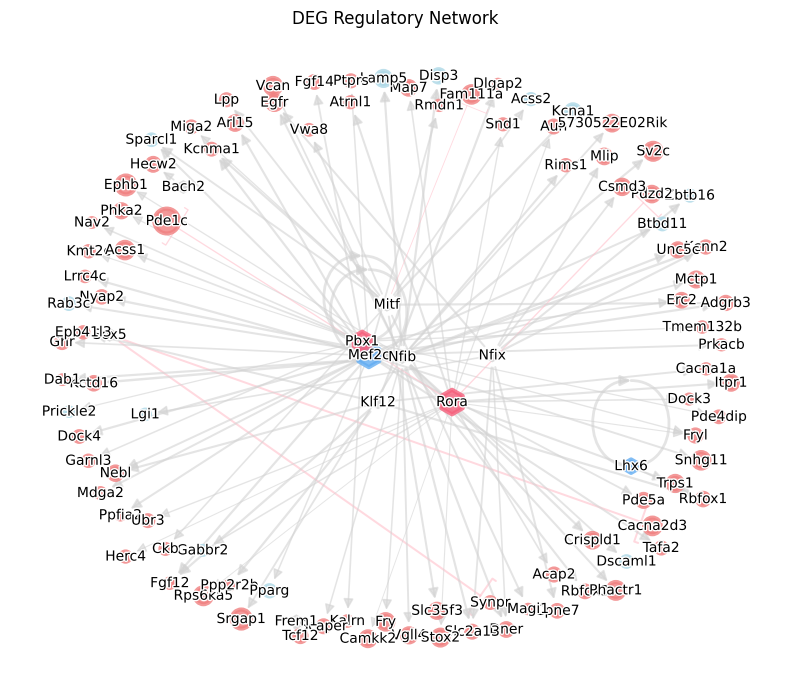

Interactive visualization saved to figures/PFC_PFC_GABA_deg_network.html


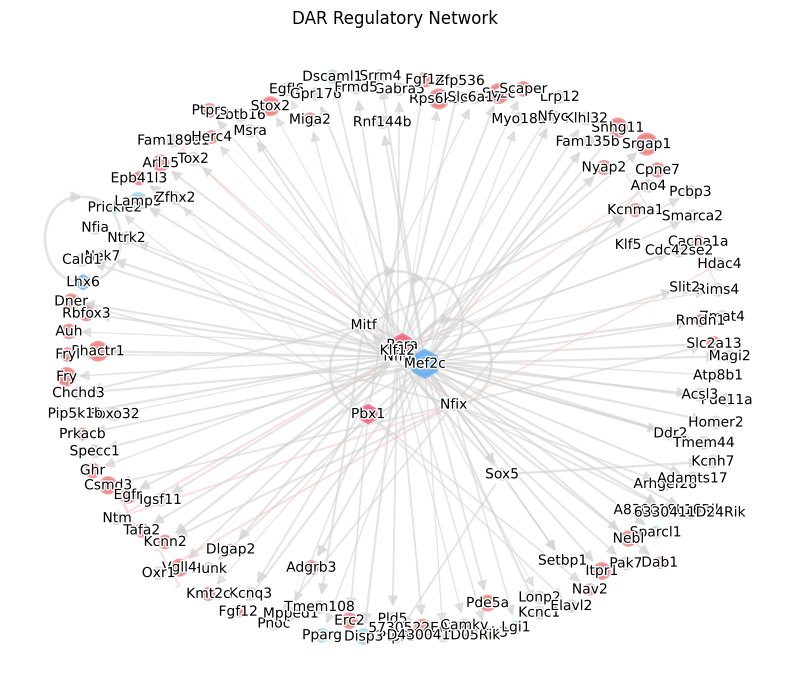

Interactive visualization saved to figures/PFC_PFC_GABA_dar_network.html


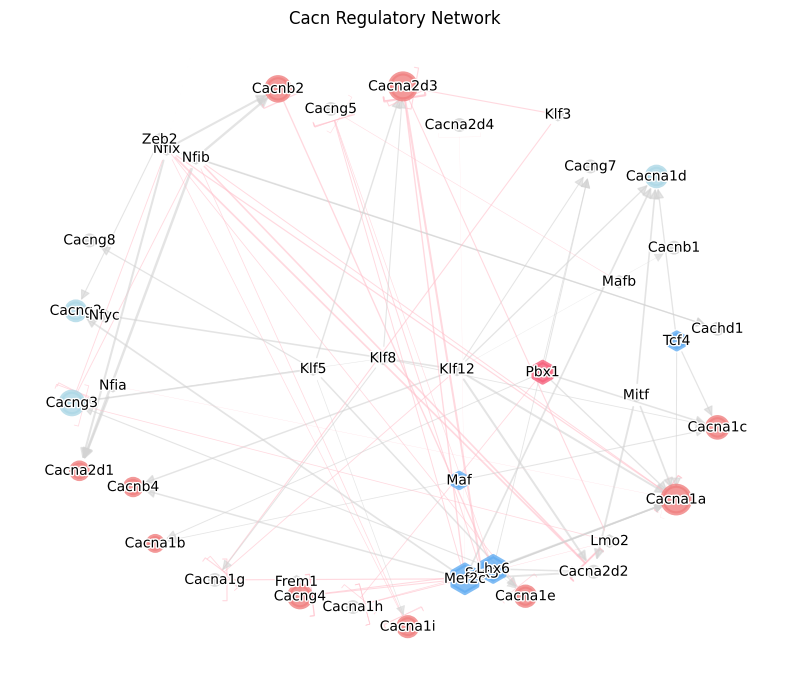

Interactive visualization saved to figures/PFC_PFC_GABA_ca_network.html


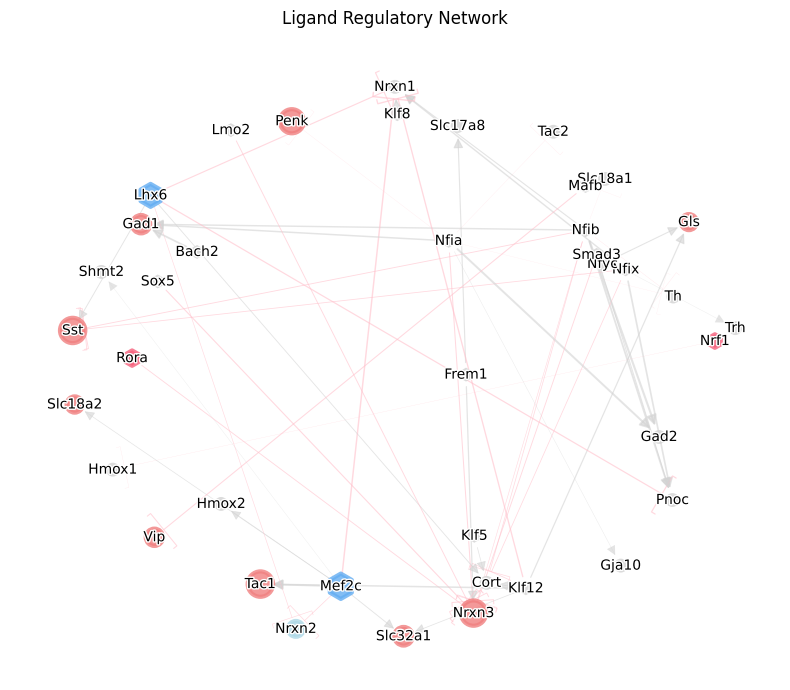

Interactive visualization saved to figures/PFC_PFC_GABA_ligand_network.html


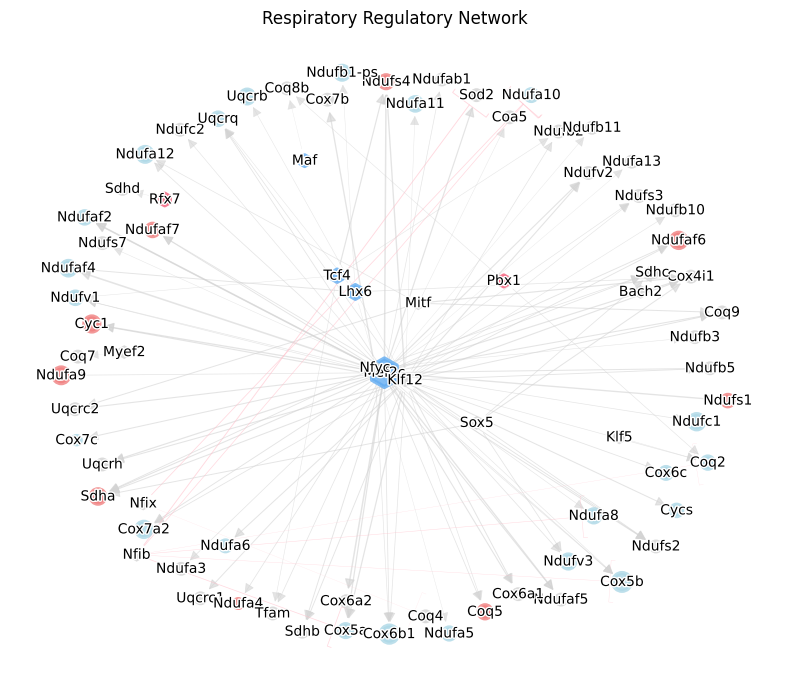

Interactive visualization saved to figures/PFC_PFC_GABA_respiratory_network.html


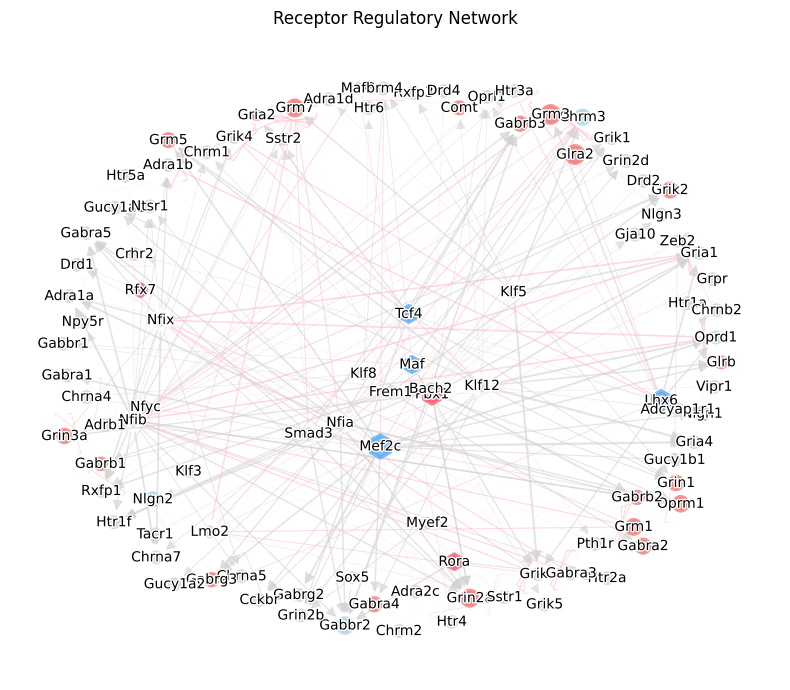

Interactive visualization saved to figures/PFC_PFC_GABA_receptor_network.html


/home/junyichen/anaconda3/envs/scenicplus/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/junyichen/anaconda3/envs/scenicplus/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/junyichen/anaconda3/envs/scenicplus/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/junyichen/anaconda3/envs/scenicplus/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/junyichen/anaconda3/envs/scenicplus/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


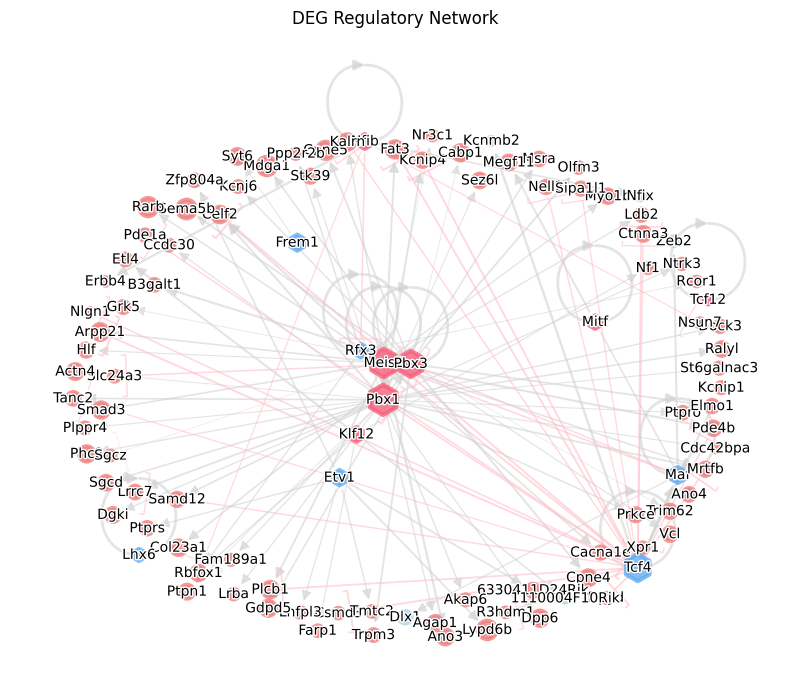

Interactive visualization saved to figures/AMY_AMY_GABA_deg_network.html


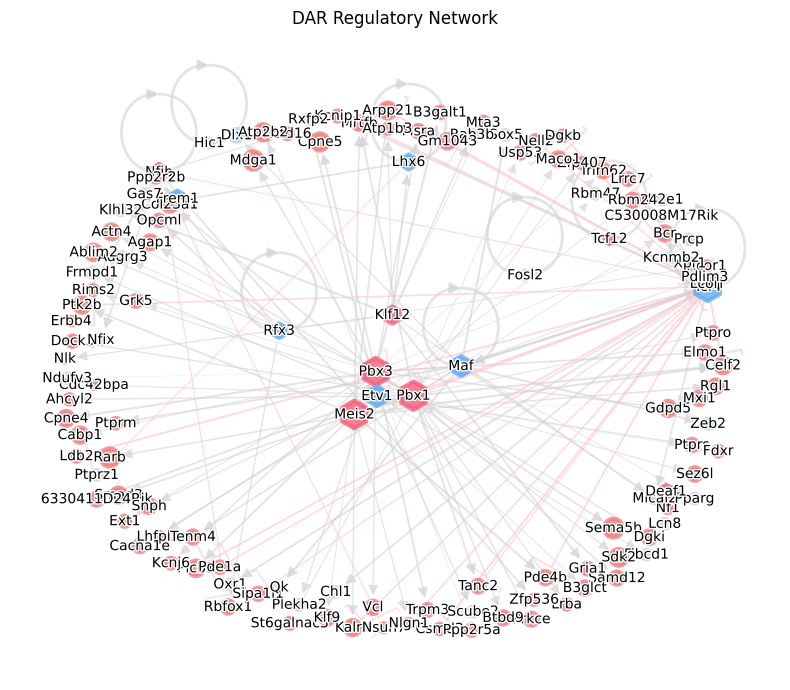

Interactive visualization saved to figures/AMY_AMY_GABA_dar_network.html


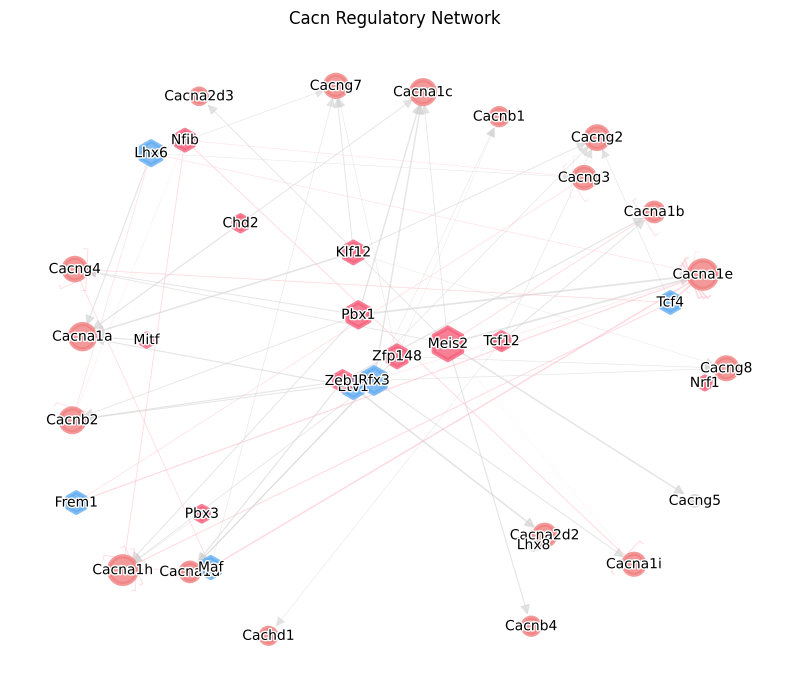

Interactive visualization saved to figures/AMY_AMY_GABA_ca_network.html


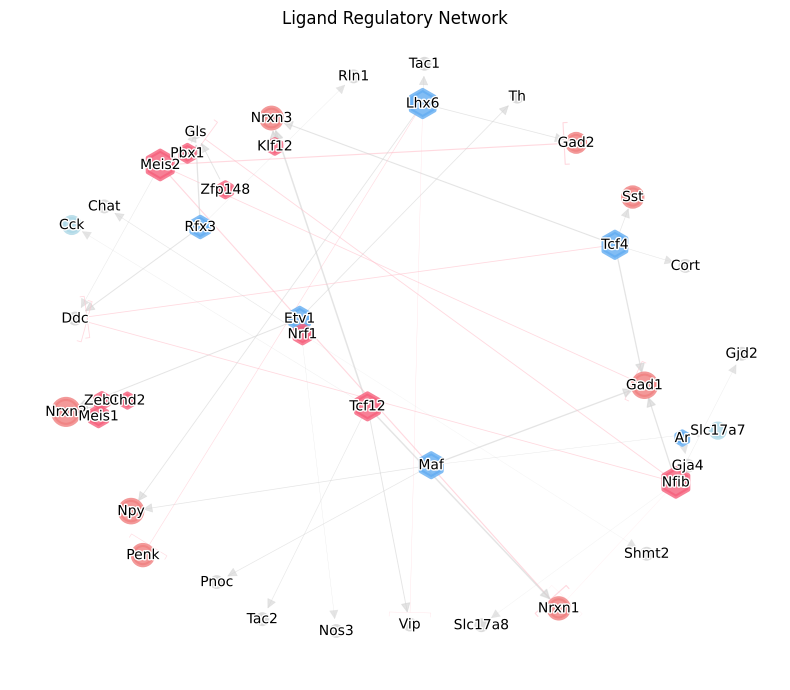

Interactive visualization saved to figures/AMY_AMY_GABA_ligand_network.html


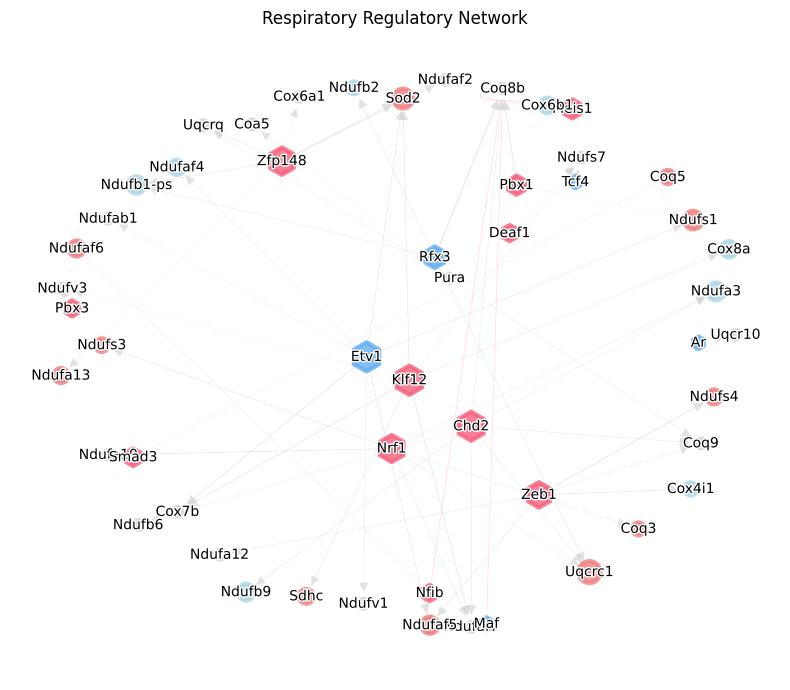

Interactive visualization saved to figures/AMY_AMY_GABA_respiratory_network.html


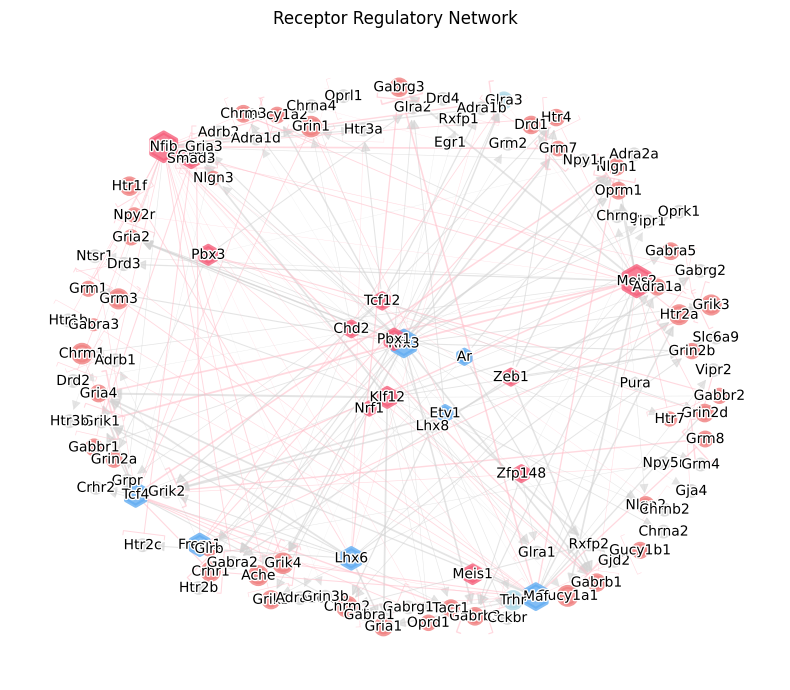

Interactive visualization saved to figures/AMY_AMY_GABA_receptor_network.html


/home/junyichen/anaconda3/envs/scenicplus/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/junyichen/anaconda3/envs/scenicplus/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/junyichen/anaconda3/envs/scenicplus/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/junyichen/anaconda3/envs/scenicplus/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/junyichen/anaconda3/envs/scenicplus/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


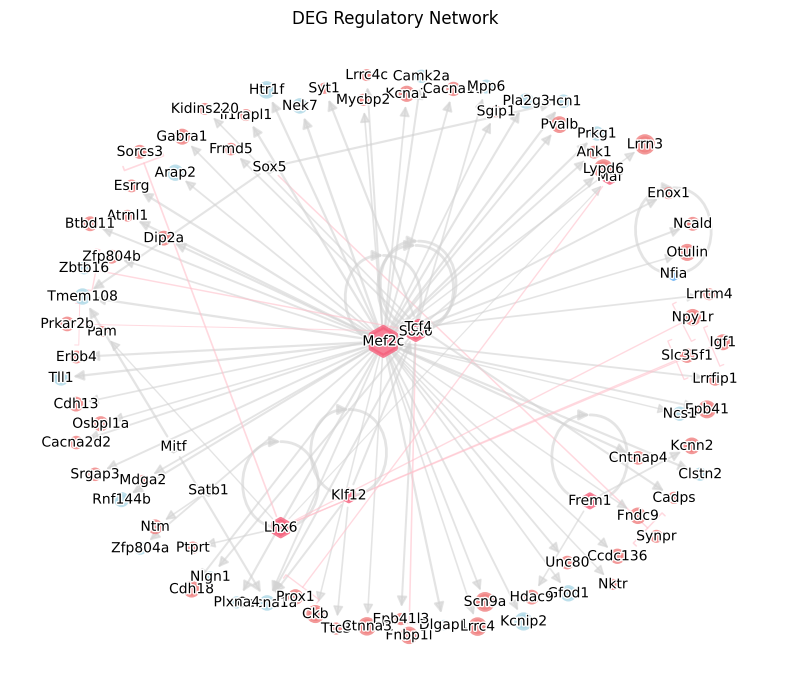

Interactive visualization saved to figures/HIP_HIP_GABA_deg_network.html


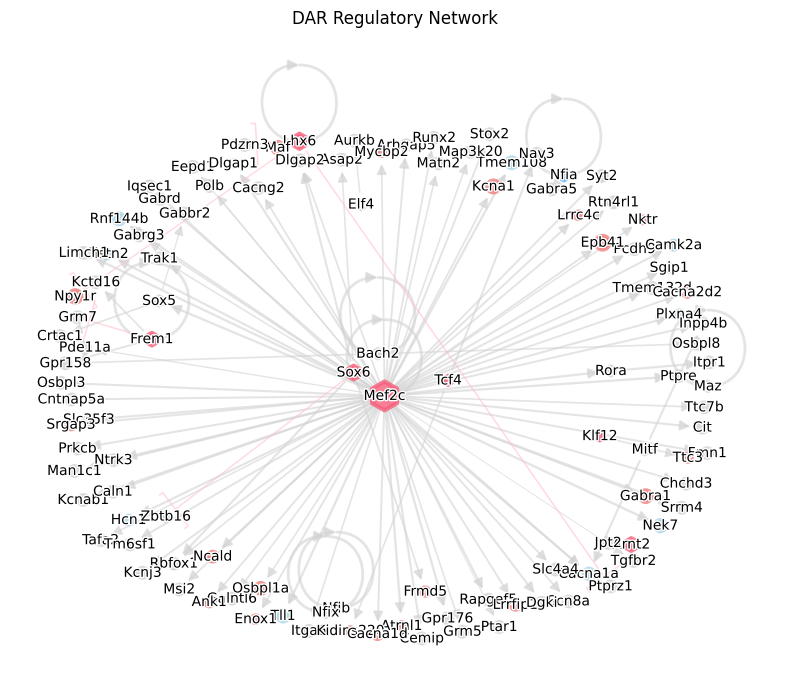

Interactive visualization saved to figures/HIP_HIP_GABA_dar_network.html


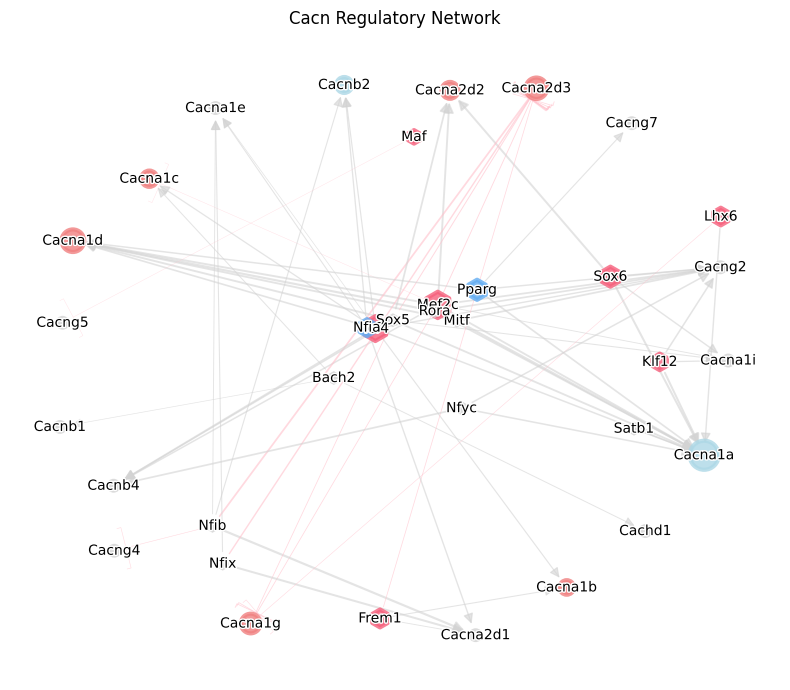

Interactive visualization saved to figures/HIP_HIP_GABA_ca_network.html


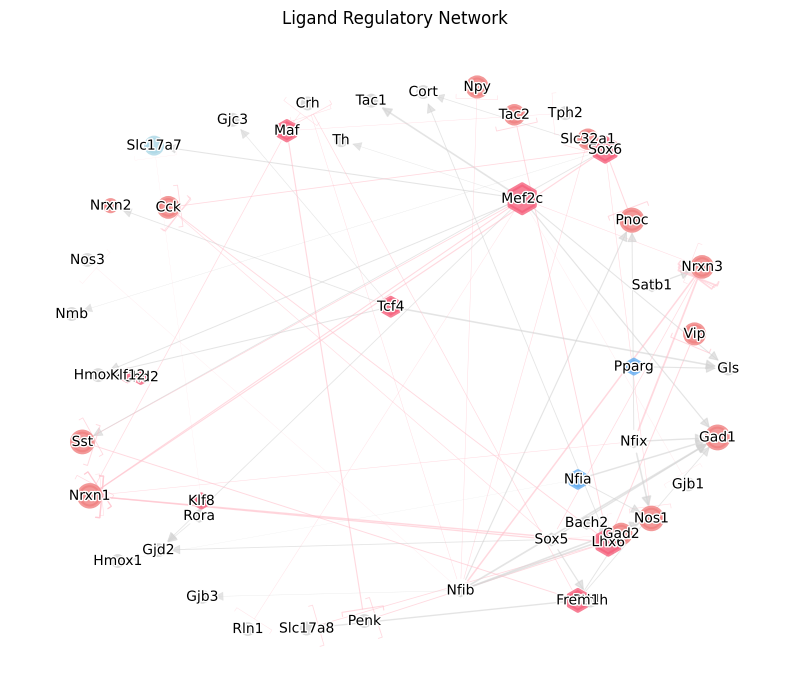

Interactive visualization saved to figures/HIP_HIP_GABA_ligand_network.html


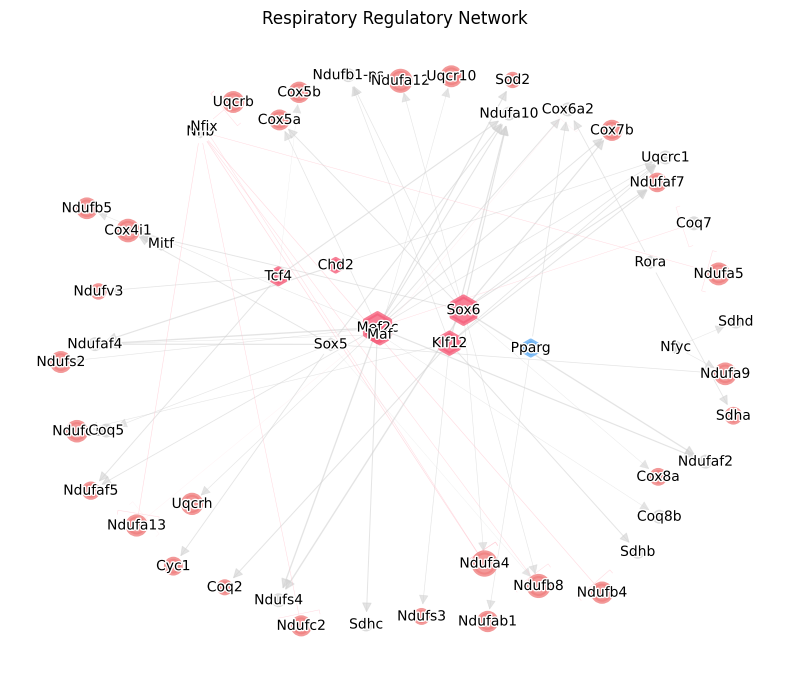

Interactive visualization saved to figures/HIP_HIP_GABA_respiratory_network.html


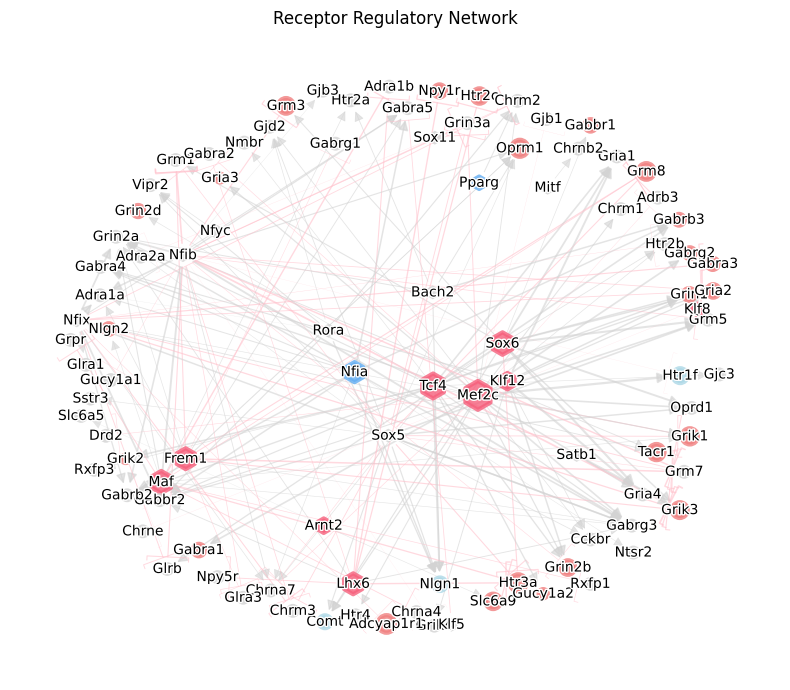

Interactive visualization saved to figures/HIP_HIP_GABA_receptor_network.html


In [289]:
cellltypes = ['PFC_PFC_GABA', 'AMY_AMY_GABA', 'HIP_HIP_GABA'
              #,'PFC_PFC_Glut', 'AMY_AMY_Glut', 'HIP_HIP_Glut'
              ]
for cellltype in cellltypes:
    ctname = cellltype[4:]
    df_deg_select = df_deg[df_deg['ctname'] == ctname]
    oudir = f'/data1st2/junyi/output/atac0416/scenic/{cellltype}/Snakemake'
    scplus_mdata = mudata.read(f'{oudir}/scplusmdata.h5mu')

    direct_er = scplus_mdata.uns["direct_e_regulon_metadata"]
    direct_er.sort_values(['importance_TF2G'], ascending=False, inplace=True)
    deg = direct_er[direct_er.Gene.isin(df_deg_select.gene)].copy()
    visualize_regulatory_network(deg,importance_col='importance_TF2G',weight_col='rho_TF2G',df_deg=df_deg_select, top_n=min(400,len(deg)),title='DEG Regulatory Network',output_html=f'figures/{cellltype}_deg_network.html')

    dar = direct_er[direct_er['Region'].isin(df_dar['names'].unique())].copy()
    visualize_regulatory_network(dar,importance_col='importance_TF2G',weight_col='rho_TF2G',df_deg=df_deg_select, top_n=min(250,len(dar)),title='DAR Regulatory Network',output_html=f'figures/{cellltype}_dar_network.html')


    TF_gcount = pd.DataFrame(direct_er.groupby(['TF']).nunique()['Gene'].sort_values(ascending=False))
    TF_degcount = pd.DataFrame(deg.groupby(['TF']).nunique()['Gene'])
    df_importance = TF_degcount.merge(TF_gcount, left_index=True, right_index=True, how='right', suffixes=('_deg', '_all')).fillna(0)
    df_importance['degratio'] = df_importance['Gene_deg'] / df_importance['Gene_all']
    df_importance.sort_values('degratio', ascending=False, inplace=True)
    df_importance['ctname'] = ctname
    df_importance.to_csv(f'figures/{cellltype}_TF_deg_ratio.csv')
    ca_df = direct_er[direct_er.Gene.isin(ca_genes)].copy()
    visualize_regulatory_network(ca_df,importance_col='importance_TF2G',weight_col='rho_TF2G',df_deg=df_deg_select, top_n=len(ca_df),title='Cacn Regulatory Network',output_html=f'figures/{cellltype}_ca_network.html')

    ligand_df = direct_er[direct_er.Gene.isin(ligand)].copy()

    visualize_regulatory_network(ligand_df,importance_col='importance_TF2G',weight_col='rho_TF2G', top_n=len(ligand_df),title='Ligand Regulatory Network',df_deg=df_deg_select,output_html=f'figures/{cellltype}_ligand_network.html')

    atp_df = direct_er[direct_er.Gene.isin(respriotory)].copy()

    visualize_regulatory_network(atp_df,importance_col='importance_TF2G',weight_col='rho_TF2G',df_deg=df_deg_select, top_n=len(atp_df),title='Respiratory Regulatory Network',output_html=f'figures/{cellltype}_respiratory_network.html')

    receptor_df = direct_er[direct_er.Gene.isin(receptor)].copy()

    visualize_regulatory_network(receptor_df,importance_col='importance_TF2G',weight_col='rho_TF2G', top_n=len(receptor_df),title='Receptor Regulatory Network',df_deg=df_deg_select,output_html=f'figures/{cellltype}_receptor_network.html')


In [ ]:
accgex = mudata.read(f'/data1st2/junyi/output/atac0416/scenic/PFC_PFC_GABA/Snakemake/ACC_GEX.h5mu')


In [ ]:
accgex['scRNA'].obs

In [ ]:
scplus_mdata.uns['direct_e_regulon_metadata']

In [239]:
import glob as glob
df_globs = glob.glob('figures/*_TF**csv')

In [240]:
all_df = pd.DataFrame()
for df_glob in df_globs:
    df = pd.read_csv(df_glob).head(20)
    
    all_df = pd.concat([all_df, df], axis=0, ignore_index=True)

In [243]:
all_df["NT"] = all_df["ctname"].str.split('_').str[1]
all_df["Region"] = all_df["ctname"].str.split('_').str[0]

In [ ]:
all_df.groupby(['TF','NT']).nunique()['ctname'].sort_values(ascending=False)

Gene_deg  Gene_all  degratio  ctname  Region
TF     NT                                                
Ar     GABA         1         1         1       1       1
Arnt2  GABA         2         2         2       2       2
       Glut         1         1         1       1       1
Arntl  Glut         1         1         1       1       1
Atf2   Glut         1         1         1       1       1
...               ...       ...       ...     ...     ...
Tcf4   Glut         3         3         3       3       3
Uncx   Glut         1         1         1       1       1
Zeb1   GABA         1         1         1       1       1
Zfp148 GABA         1         1         1       1       1
       Glut         2         2         2       2       2

[77 rows x 5 columns]

In [ ]:


eRegulon_gene_AUC = anndata.concat(
    [scplus_mdata["direct_gene_based_AUC"], scplus_mdata["extended_gene_based_AUC"]],
    axis = 1,
)


In [ ]:
scplus_mdata['direct_region_based_AUC'].var

In [ ]:
scplus_mdata['direct_region_based_AUC']

In [ ]:
scplus_mdata.uns["direct_e_regulon_metadata"].to_csv(
    "/data1st2/junyi/output/atac0416/scenic/AMY_AMY_Glut/direct_e_regulon_metadata.csv"
)


In [ ]:
eRegulon_gene_AUC.obs = scplus_mdata.obs.loc[eRegulon_gene_AUC.obs_names]


In [ ]:
sc.pp.neighbors(eRegulon_gene_AUC, use_rep = "X")


In [ ]:
sc.tl.umap(eRegulon_gene_AUC)


In [ ]:
eRegulon_gene_AUC.obs['celltype.L2'] = eRegulon_gene_AUC.obs.index.str.split("_").str[:-1].str.join("_")

In [ ]:
sc.pl.umap(eRegulon_gene_AUC, color = ['celltype.L2'])


In [ ]:
scplus_mdata.obs['celltype.L2'] = scplus_mdata.obs.index.str.split("_").str[:-1].str.join("_")

In [ ]:
from scenicplus.RSS import (regulon_specificity_scores, plot_rss)


In [ ]:
rss = regulon_specificity_scores(
    scplus_mudata = scplus_mdata,
    variable = "celltype.L2",
    modalities = ["direct_gene_based_AUC", "extended_gene_based_AUC"]
)


In [ ]:
plot_rss(
    data_matrix = rss,
    top_n = 3,
    num_columns = 3
)

In [ ]:
from scenicplus.plotting.dotplot import heatmap_dotplot
heatmap_dotplot(
    scplus_mudata = scplus_mdata,
    color_modality = "direct_gene_based_AUC",
    size_modality = "direct_region_based_AUC",
    group_variable = "celltype.L2",
    eRegulon_metadata_key = "direct_e_regulon_metadata",
    color_feature_key = "Gene_signature_name",
    size_feature_key = "Region_signature_name",
    feature_name_key = "eRegulon_name",
    sort_data_by = "direct_gene_based_AUC",
    orientation = "horizontal",
    figsize = (16, 5)
)